# Removing noise
This exercise uses PDAL to remove unwanted noise in an ALS collection.

## Exercise
PDAL provides the outlier filter to apply a statistical filter to data.

Because this operation is somewhat complex, we are going to use a pipeline to define it.

In [15]:
%matplotlib inline

import os
import sys

import matplotlib.pyplot as plt
import pdal
import numpy as np
from sklearn.neighbors.kde import KernelDensity
from six.moves.urllib.request import urlretrieve

If you've run the previous tutorials, then you probably already have the data, but if not, this will download some sample data.

In [8]:
url = 'https://github.com/PDAL/data/raw/master/isprs/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

pc_filename = maybe_download('samp11-utm.laz', 99563)
# pc_filename = maybe_download('CSite1_orig-utm.laz', 4539968)

('Found and verified', './samp11-utm.laz')


## Pipeline breakdown

### 1. Reader

### 2. filters.outlier
The PDAL outlier filter does most of the work for this operation.

```json
{
  "type": "filters.outlier",
  "method": "statistical",
  "multiplier": 3,
  "mean_k": 8
},
```

In [3]:
pc_filename='./S1C1_csd_004.csd'
json = u'''
{
  "pipeline":[
    "%s"
  ]
}''' % pc_filename

p = pdal.Pipeline(json)
p.validate()
p.loglevel = 8
count = p.execute()
log = p.log
print(log)

In [4]:
print(count)

7418613


In [6]:
data = p.arrays[0]

In [7]:
data.dtype.names

(u'X',
 u'Y',
 u'Z',
 u'GpsTime',
 u'ReturnNumber',
 u'NumberOfReturns',
 u'EchoRange',
 u'Intensity',
 u'ScanAngleRank')

In [8]:
def dim_kde(arr, lb, ub, n=500, bw=0.25, k='epanechnikov'):
    f = plt.figure()
    xp = np.linspace(lb, ub, n)[:, np.newaxis]
    kde = KernelDensity(kernel=k, bandwidth=bw).fit(arr[:, np.newaxis])
    log_pdf = kde.score_samples(xp)
    # We add a few lines here to identify the peak of the KDE and report its location and magnitude.
    ind = np.argmax(np.exp(log_pdf))
    print(np.exp(log_pdf)[ind],xp[ind])
    ax = f.add_subplot(111)
    ax.plot(xp, np.exp(log_pdf))

In [12]:
data['Intensity'].min(), data['Intensity'].max(), data['Intensity'].mean()

(0, 15794, 162.79404775528795)

(0.0070375580929971353, array([ 173.62626263]))


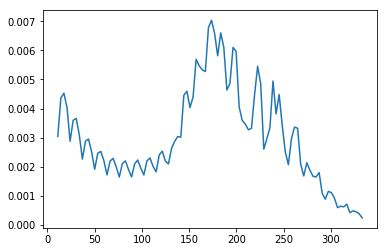

In [19]:
dim_kde(data['Intensity'], 11, 333, n=100, bw=1.0)

In [18]:
np.percentile(data['Intensity'],2)

11.0

In [20]:
pc_filename='./S1C1_csd_004.csd'
json = u'''
{
  "pipeline":[
    "%s",
    {
      "type":"filters.reprojection",
      "out_srs":"EPSG:32614"
    },
    {
      "type":"filters.range",
      "limits":"Intensity[:333]"
    },
    "./S1C1_csd_004.laz"
  ]
}''' % pc_filename

p = pdal.Pipeline(json)
p.validate()
p.loglevel = 8
count = p.execute()
log = p.log
print(count,'\n',log)

(7272482, '\n', u'(pypipeline writers.las Debug) Wrote 7272482 points to the LAS file\n')


In [21]:
data2 = p.arrays[0]

(-97.996626850103326, -97.992172153347468, -97.994376680737219)

In [22]:
data2['X'].min(), data2['X'].max(), data2['X'].mean()

(596817.36393247196, 597271.79786267015, 597049.09491513984)